<a href="https://colab.research.google.com/github/jakelourie1502/Comparison_of_image_classifiers/blob/main/Comparison_of_ResNet_and_GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

     |████████████████████████████████| 409 kB 14.6 MB/s 


In [ ]:
import json
import numpy as np
import torch
import torchvision.models as models
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torchvision.datasets.mnist as tMnist
import torchvision.datasets.cifar as tCifar
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torchmetrics
from torch.utils.data.sampler import SubsetRandomSampler
random_seed = np.random.seed(42)
import datetime;
import seaborn as sns
import os
import pprint
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device


device(type='cuda')

# Helper Functions

In [ ]:
######## Loading things once stored in folder

def load_logs_N_heatmap(dataset_name, model_name):
  folder = f'{os.getcwd()}/{model_name}_{dataset_name}/logs'
  with open(f'{folder}/loss_and_accuracy.json', 'r') as fp:
    logs = json.load(fp)
  heatmap = np.load(f'{folder}/heatmap.npy')
  return logs, heatmap

def load_checkpoint(dataset_name, model_name, epoch = 2):
  folder = f'{os.getcwd()}/{model_name}_{dataset_name}/checkpoints'
  file = f'{folder}/{epoch}{model_name}{dataset_name}.pt'
  return torch.load(file)

#### Plotting visualisations of performance

def plot_confmatrix(heatmap):
  plt.figure(figsize=(10,6))
  sns.heatmap(heatmap, annot=True);
  plt.ylabel('predicted')
  plt.xlabel('true')
  plt.plot()

def plot_loss_and_accs(logs,title):
  loss = []
  train_acc= []
  val_acc = []
  for k,v in logs.items():
    if k[:5] == 'Epoch':
      loss.append(v['loss'])
      train_acc.append(v['train_accuracy'])
      val_acc.append(v['val_accuracy'])
  fig, axlist = plt.subplots(figsize=(12,6),nrows=1,ncols=2)
  axlist[0].plot(loss)
  axlist[0].set_title("Loss")
  axlist[1].plot(train_acc, label='Train accuracy')
  axlist[1].plot(val_acc,label="Val accuracy")
  axlist[1].set_title("Accuracies")
  axlist[1].legend()
  axlist[0].set_xlabel("Epoch")
  axlist[1].set_xlabel("Epoch")
  fig.suptitle(title)

#investigating classes

def investigate_classes(checkpoint,dataset, classes_inv):

    model = torch.load(checkpoint).to(device)
    one_at_a_time_loader_cifar_aug = torch.utils.data.DataLoader(dataset, batch_size=1,
                                              num_workers=4,shuffle=True)

    pos_examples = 4
    neg_examples = 4
    ps_cntr = 0
    ng_cntr = 0
    posses = {}; posses['ims'] = []; posses['true_labels'] = []
    negs = {}; negs['ims'] = [] ; negs['true_labels'] = []; negs['predicted_labels'] = []

    model.eval()
    with torch.no_grad():

        for x, y in one_at_a_time_loader_cifar_aug:
          if (ps_cntr < pos_examples or ng_cntr < neg_examples):
            if y not in classes_inv:
              continue
            x=x.to(device).float()
            y=y.to(device).long()
            output = model(x)[0]
            
            prediction = torch.argmax(output)
            
            if prediction == y and ps_cntr < pos_examples:
              ps_cntr+=1
              posses['ims'].append(x)
              posses['true_labels'].append(int(y))
            if prediction != y and ng_cntr < neg_examples:
              ng_cntr+=1
              negs['ims'].append(x)
              negs['true_labels'].append(int(y))
              negs['predicted_labels'].append(int(prediction))
          else:
            break
    return posses, negs


In [ ]:
##### Training loops

def create_folders(model_name, dataset_name):
    log_folder = os.getcwd()+'/'+model_name+'_'+dataset_name+'/logs'
    checkpoint_folder = os.getcwd()+'/'+model_name+'_'+dataset_name+'/checkpoints'
    if not os.path.exists(log_folder):
      os.mkdir(os.getcwd()+'/'+model_name+'_'+dataset_name)
      os.mkdir(log_folder)  
      os.mkdir(checkpoint_folder)
    return log_folder, checkpoint_folder


def train_loop(model,class_list,train_loader, val_loader, test_loader, epochs, optimizer, loss_func, accuracy_metric, dataset_name='mnist',model_name='resnet',patience=10):
    best_epoch = 0
    best_perf = 0.0
    early_stop_counter = 0
    log_folder, checkpoint_folder = create_folders(model_name,dataset_name)

    logs = {}

    for e in range(epochs):
        model.train()
        print("Epoch: ", e)
        #train
        loss_cum = 0
        logs[f'Epoch{e}'] = {}
        ct = datetime.datetime.now()
        print("Time: ", str(ct))
        logs[f'Epoch{e}']['time_stamp'] = str(ct)
        for data in train_loader:
            x , y = data
            x, y = x.to(device), y.long().to(device)
            outputs = model(x)
            loss = loss_func(outputs, y)
            loss_cum += loss.item()
            loss.backward()
            optimizer.step(); optimizer.zero_grad()
            accuracy_metric(outputs,y)
        acc = accuracy_metric.compute()

        print('Train Accuracy: ', acc)
        logs[f'Epoch{e}']['loss'] = (loss_cum * batch_size / len(train_loader))
        logs[f'Epoch{e}']['train_accuracy'] = float(acc.detach().cpu().numpy())
        accuracy_metric.reset()
        torch.save(model, f'{checkpoint_folder}/{e}{model_name}{dataset_name}.pt')
        #validation
        model.eval()
        with torch.no_grad():
          for data in val_loader:
              x , y = data
              x, y = x.to(device), y.long().to(device)
              outputs = model(x)
              accuracy_metric(outputs,y)
        acc = accuracy_metric.compute()

        logs[f'Epoch{e}']['val_accuracy'] = float(acc.detach().cpu().numpy())
        print('Val Accuracy: ', acc)
        if acc > best_perf + 0.001:
          best_epoch =e
          early_stop_counter = 0
          best_perf = acc.item()
        else:
          early_stop_counter += 1
        accuracy_metric.reset()
        if early_stop_counter > patience:
          break
    #testing
    model.eval()
    test_log = {}
    test_log['timestamp'] = str(datetime.datetime.now())
    classes = set([int(x) for x in (class_list)])
    heatmap_array = np.zeros((len(classes), len(classes)))
    classes_acc = {}
    for c in classes:
      classes_acc[c] = {'N':0, 'correct':0}

    with torch.no_grad():
      for data in test_loader:
          x , y = data  
          x, y = x.to(device), y.long().to(device)
          outputs = model(x)
          accuracy_metric(outputs,y)
          prediction = torch.argmax(outputs, dim=1, keepdim=False)
          for c in classes:
            classes_acc[c]['N'] += int((torch.sum(y == c)).detach().cpu().numpy())
            classes_acc[c]['correct'] += int((torch.sum((y==c) * (y==prediction))).detach().cpu().numpy())
          for pred, true in zip(prediction, y):
            heatmap_array[pred,true] += 1
    for c in classes:
      classes_acc[c]['accuracy'] = classes_acc[c]['correct'] / classes_acc[c]['N']
    test_log['ind. class breakdown'] = classes_acc
    acc = accuracy_metric.compute()
    test_log['overall_accuracy'] = float(acc.detach().cpu().numpy())
    logs['Test log'] = test_log
    print('Test Accuracy: ', acc)
    accuracy_metric.reset()
    
    with open(log_folder+'/loss_and_accuracy.json', "w") as fp:
      json.dump(logs,fp)  
    np.save(log_folder+'/heatmap.npy', heatmap_array)
    
    return logs, heatmap_array

def train_loop_googleNet(model,class_list,train_loader, val_loader, test_loader, epochs, optimizer, loss_func, accuracy_metric, dataset_name='mnist',model_name='resnet',patience=10):
    best_epoch = 0
    best_perf = 0.0
    early_stop_counter = 0
    log_folder, checkpoint_folder = create_folders(model_name,dataset_name)

    logs = {}
    for e in range(epochs):
        print("Epoch: ", e)
        #train
        loss_cum = 0
        logs[f'Epoch{e}'] = {}
        ct = datetime.datetime.now()
        print("Time: ", str(ct))
        logs[f'Epoch{e}']['time_stamp'] = str(ct)
        for data in train_loader:
            x , y = data
            x, y = x.to(device), y.long().to(device)
            outputs = model(x)
            loss = loss_func(outputs[0], y)
            loss += 0.3 * loss_func(outputs[1], y)
            loss += 0.3 * loss_func(outputs[2], y)
            loss_cum += loss.item()
            loss.backward()
            optimizer.step(); optimizer.zero_grad()
            accuracy_metric(outputs[0],y)
        acc = accuracy_metric.compute()

        print('Train Accuracy: ', acc)
        logs[f'Epoch{e}']['loss'] = (loss_cum * batch_size / len(train_loader))
        logs[f'Epoch{e}']['train_accuracy'] = float(acc.detach().cpu().numpy())
        accuracy_metric.reset()
        torch.save(model, f'{checkpoint_folder}/{e}{model_name}{dataset_name}.pt')
        #validation
        with torch.no_grad():
          for data in val_loader:
              x , y = data
              x, y = x.to(device), y.long().to(device)
              outputs = model(x)
              accuracy_metric(outputs[0],y)
        acc = accuracy_metric.compute()

        logs[f'Epoch{e}']['val_accuracy'] = float(acc.detach().cpu().numpy())
        print('Val Accuracy: ', acc)
        if acc > best_perf + 0.001:
          best_epoch =e
          early_stop_counter = 0
          best_perf = acc.item()
          print("New Best: ", best_perf)
        else:
          early_stop_counter += 1
          print(early_stop_counter)
        accuracy_metric.reset()
        if early_stop_counter > patience:
          break
        

    #testing
    test_log = {}
    test_log['timestamp'] = str(datetime.datetime.now())
    classes = set([int(x) for x in (class_list)])
    heatmap_array = np.zeros((len(classes), len(classes)))
    classes_acc = {}
    for c in classes:
      classes_acc[c] = {'N':0, 'correct':0}

    with torch.no_grad():
      for data in test_loader:
          x , y = data  
          x, y = x.to(device), y.long().to(device)
          outputs = model(x)
          accuracy_metric(outputs[0],y)
          prediction = torch.argmax(outputs[0], dim=1, keepdim=False)
          for c in classes:
            classes_acc[c]['N'] += int((torch.sum(y == c)).detach().cpu().numpy())
            classes_acc[c]['correct'] += int((torch.sum((y==c) * (y==prediction))).detach().cpu().numpy())
          for pred, true in zip(prediction, y):
            heatmap_array[pred,true] += 1
    for c in classes:
      classes_acc[c]['accuracy'] = classes_acc[c]['correct'] / classes_acc[c]['N']
    test_log['ind. class breakdown'] = classes_acc
    acc = accuracy_metric.compute()
    test_log['overall_accuracy'] = float(acc.detach().cpu().numpy())
    logs['Test log'] = test_log
    print('Test Accuracy: ', acc)
    accuracy_metric.reset()
    
    with open(log_folder+'/loss_and_accuracy.json', "w") as fp:
      json.dump(logs,fp)  
    np.save(log_folder+'/heatmap.npy', heatmap_array)
    
    return logs, heatmap_array


# MNIST

## DataSet

In [ ]:
##### Create dataloaders

mnist_train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.), (0.5))])

mnist_val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.), (0.5))])


mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=mnist_train_transform)
mnist_valset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=mnist_val_transform)

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=mnist_val_transform)

### Creating validation sampler
validation_percentage = 0.1
num_train = len(mnist_trainset)
indices = list(range(num_train))
split = int(validation_percentage * num_train)

#randomise the indices
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx) #this is an object the dataloader then needs
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 128

#CREATE DATALOADERS
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)

mnist_val_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size,
                                           num_workers=4, sampler = valid_sampler)
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size,
                                           num_workers=4)
mnist_classes  = list(set(mnist_testset.targets))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/cv_project')

Mounted at /content/drive


In [ ]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/cv_project'

In [ ]:
for f in os.listdir(os.getcwd()):
    if 'ipynb' not in f:
      for g in os.listdir(f'{os.getcwd()}/{f}'):
        if g == 'checkpoints':
          for file in os.listdir(f'{os.getcwd()}/{f}/{g}'):
            print(file)
            os.remove(f'{os.getcwd()}/{f}/{g}/{file}')
          os.rmdir(f'{os.getcwd()}/{f}/{g}')
            
          

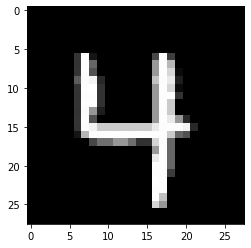

In [ ]:
# showing an image
dataiter = iter(mnist_train_loader)
images, labels = dataiter.next()
plt.imshow(images[0].reshape(28,28),'gray')

## Resnet18

In [ ]:
# summary(resnet18, (1, 28, 28))

Epoch:  0
Time:  2022-05-09 14:21:35.174911
Train Accuracy:  tensor(0.9675, device='cuda:0')
Val Accuracy:  tensor(0.9853, device='cuda:0')
Epoch:  1
Time:  2022-05-09 14:21:55.670945
Train Accuracy:  tensor(0.9873, device='cuda:0')
Val Accuracy:  tensor(0.9877, device='cuda:0')
Epoch:  2
Time:  2022-05-09 14:22:15.418342
Train Accuracy:  tensor(0.9910, device='cuda:0')
Val Accuracy:  tensor(0.9920, device='cuda:0')
Epoch:  3
Time:  2022-05-09 14:22:35.275587
Train Accuracy:  tensor(0.9922, device='cuda:0')
Val Accuracy:  tensor(0.9795, device='cuda:0')
Epoch:  4
Time:  2022-05-09 14:22:55.250616
Train Accuracy:  tensor(0.9932, device='cuda:0')
Val Accuracy:  tensor(0.9915, device='cuda:0')
Epoch:  5
Time:  2022-05-09 14:23:15.022667
Train Accuracy:  tensor(0.9943, device='cuda:0')
Val Accuracy:  tensor(0.9868, device='cuda:0')
Epoch:  6
Time:  2022-05-09 14:23:34.887673
Train Accuracy:  tensor(0.9946, device='cuda:0')
Val Accuracy:  tensor(0.9908, device='cuda:0')
Epoch:  7
Time:  202

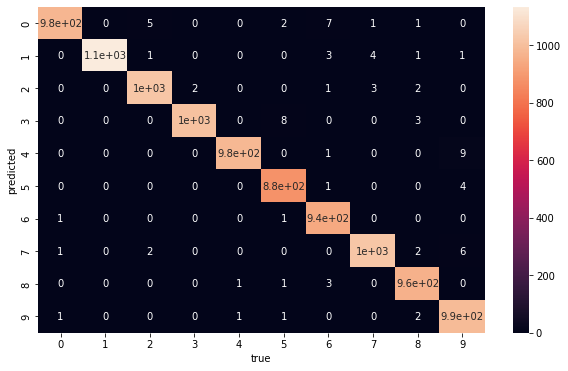

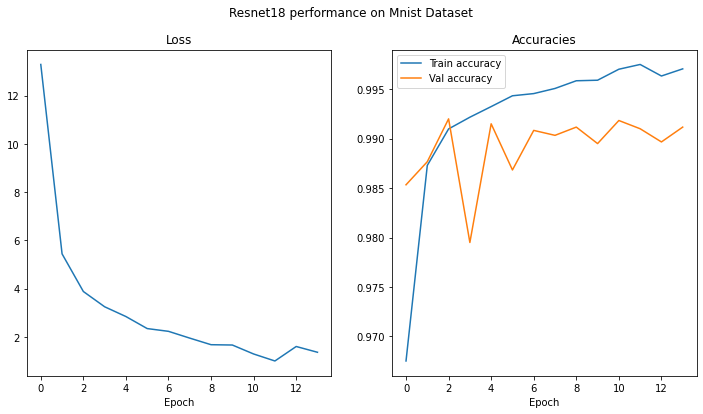

In [ ]:
resnet18 = models.resnet18().to(device)
resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).to(device)
resnet18.fc = torch.nn.Linear(512,10).to(device)
optimizer = optim.Adam(resnet18.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 50
resnet_mnist_logs, heatmap_array = train_loop(resnet18, mnist_classes, mnist_train_loader, mnist_val_loader, mnist_test_loader, epochs, optimizer, loss_func, accuracy,dataset_name='mnist',model_name='resnet')
logs, heatmap = load_logs_N_heatmap('mnist','resnet')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'Resnet18 performance on Mnist Dataset')

## GoogleNet

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:50: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


Epoch:  0
Time:  2022-05-09 14:26:17.072050


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Train Accuracy:  tensor(0.9545, device='cuda:0')
Val Accuracy:  tensor(0.9793, device='cuda:0')
New Best:  0.9793333411216736
Epoch:  1
Time:  2022-05-09 14:26:43.765100
Train Accuracy:  tensor(0.9848, device='cuda:0')
Val Accuracy:  tensor(0.9843, device='cuda:0')
New Best:  0.984333336353302
Epoch:  2
Time:  2022-05-09 14:27:10.618412
Train Accuracy:  tensor(0.9873, device='cuda:0')
Val Accuracy:  tensor(0.9873, device='cuda:0')
New Best:  0.987333357334137
Epoch:  3
Time:  2022-05-09 14:27:37.226782
Train Accuracy:  tensor(0.9903, device='cuda:0')
Val Accuracy:  tensor(0.9863, device='cuda:0')
1
Epoch:  4
Time:  2022-05-09 14:28:04.391547
Train Accuracy:  tensor(0.9910, device='cuda:0')
Val Accuracy:  tensor(0.9895, device='cuda:0')
New Best:  0.9894999861717224
Epoch:  5
Time:  2022-05-09 14:28:31.412802
Train Accuracy:  tensor(0.9927, device='cuda:0')
Val Accuracy:  tensor(0.9888, device='cuda:0')
1
Epoch:  6
Time:  2022-05-09 14:28:57.961562
Train Accuracy:  tensor(0.9932, device

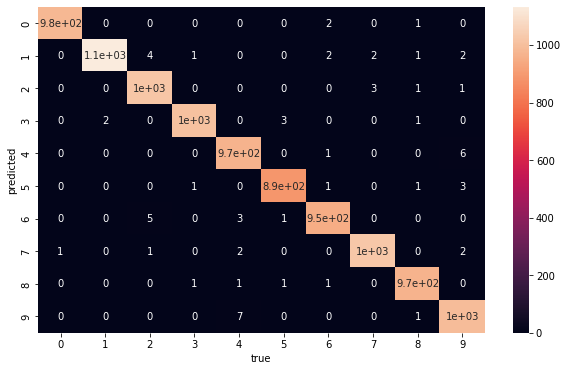

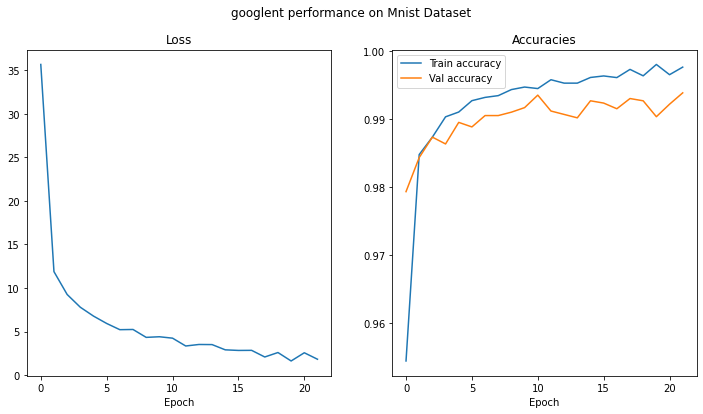

In [ ]:
googleLeNet = models.googlenet().to(device)
googleLeNet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).to(device)
googleLeNet.fc = torch.nn.Linear(1024,10).to(device)
optimizer = optim.Adam(googleLeNet.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 50
gNet_logs, heatmap_array = train_loop_googleNet(googleLeNet, mnist_classes, mnist_train_loader, mnist_val_loader, mnist_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'googlenet' )
logs, heatmap = load_logs_N_heatmap('mnist','googlenet')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'googlent performance on Mnist Dataset')

## Resnet50

Epoch:  0
Time:  2022-05-09 14:36:11.217108
Train Accuracy:  tensor(0.9458, device='cuda:0')
Val Accuracy:  tensor(0.9793, device='cuda:0')
Epoch:  1
Time:  2022-05-09 14:37:09.691566
Train Accuracy:  tensor(0.9850, device='cuda:0')
Val Accuracy:  tensor(0.9838, device='cuda:0')
Epoch:  2
Time:  2022-05-09 14:38:07.886702
Train Accuracy:  tensor(0.9897, device='cuda:0')
Val Accuracy:  tensor(0.9863, device='cuda:0')
Epoch:  3
Time:  2022-05-09 14:39:06.051535
Train Accuracy:  tensor(0.9916, device='cuda:0')
Val Accuracy:  tensor(0.9825, device='cuda:0')
Epoch:  4
Time:  2022-05-09 14:40:03.962037
Train Accuracy:  tensor(0.9934, device='cuda:0')
Val Accuracy:  tensor(0.9895, device='cuda:0')
Epoch:  5
Time:  2022-05-09 14:41:01.695471
Train Accuracy:  tensor(0.9926, device='cuda:0')
Val Accuracy:  tensor(0.9895, device='cuda:0')
Epoch:  6
Time:  2022-05-09 14:41:59.868210
Train Accuracy:  tensor(0.9951, device='cuda:0')
Val Accuracy:  tensor(0.9853, device='cuda:0')
Epoch:  7
Time:  202

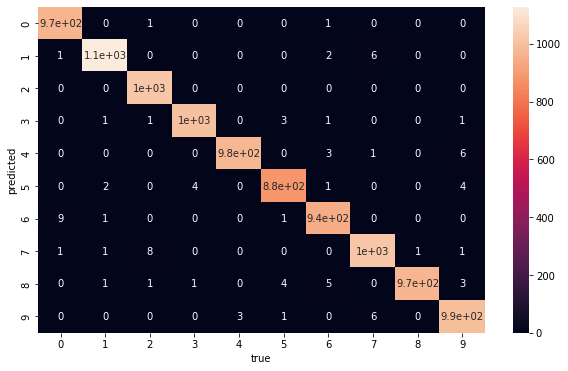

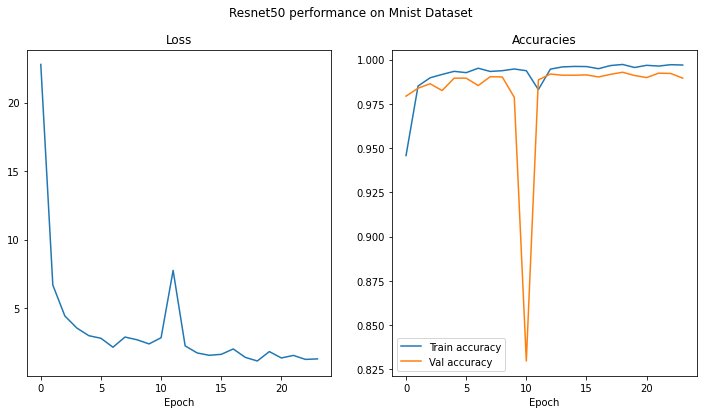

In [ ]:
resnet50 = models.resnet50().to(device)
resnet50.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).to(device)
resnet50.fc = torch.nn.Linear(2048,10).to(device)
optimizer = optim.Adam(resnet50.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 50
resnet_mnist_logs, heatmap_array = train_loop(resnet50, mnist_classes, mnist_train_loader, mnist_val_loader, mnist_test_loader, epochs, optimizer, loss_func, accuracy,dataset_name='mnist',model_name='resnet50')
logs, heatmap = load_logs_N_heatmap('mnist','resnet50')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'Resnet50 performance on Mnist Dataset')

## Transforming MNIST to three-channel inputs for EfficientNet

In [ ]:
mnist_train_transform = transforms.Compose(
    [transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize((0.), (0.5))
     ])

mnist_val_transform = transforms.Compose(
    [transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize((0.), (0.5))
     ])


mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=mnist_train_transform)
mnist_valset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=mnist_val_transform)


mnist_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=mnist_val_transform)

### Creating validation sampler
validation_percentage = 0.1
num_train = len(mnist_trainset)
indices = list(range(num_train))
split = int(validation_percentage * num_train)

#randomise the indices
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx) #this is an object the dataloader then needs
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 128

#CREATE DATALOADERS
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)

mnist_val_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size,
                                           num_workers=4, sampler = valid_sampler)
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size,
                                           num_workers=4)
mnist_classes  = list(set(mnist_testset.targets))


## EfficientNetb0

Epoch:  0
Time:  2022-05-09 14:59:34.193924
Train Accuracy:  tensor(0.8405, device='cuda:0')
Val Accuracy:  tensor(0.9687, device='cuda:0')
Epoch:  1
Time:  2022-05-09 14:59:59.847112
Train Accuracy:  tensor(0.9717, device='cuda:0')
Val Accuracy:  tensor(0.9710, device='cuda:0')
Epoch:  2
Time:  2022-05-09 15:00:25.113316
Train Accuracy:  tensor(0.9804, device='cuda:0')
Val Accuracy:  tensor(0.9788, device='cuda:0')
Epoch:  3
Time:  2022-05-09 15:00:50.114070
Train Accuracy:  tensor(0.9843, device='cuda:0')
Val Accuracy:  tensor(0.9802, device='cuda:0')
Epoch:  4
Time:  2022-05-09 15:01:15.313341
Train Accuracy:  tensor(0.9863, device='cuda:0')
Val Accuracy:  tensor(0.9808, device='cuda:0')
Epoch:  5
Time:  2022-05-09 15:01:40.221549
Train Accuracy:  tensor(0.9880, device='cuda:0')
Val Accuracy:  tensor(0.9843, device='cuda:0')
Epoch:  6
Time:  2022-05-09 15:02:05.533844
Train Accuracy:  tensor(0.9892, device='cuda:0')
Val Accuracy:  tensor(0.9873, device='cuda:0')
Epoch:  7
Time:  202

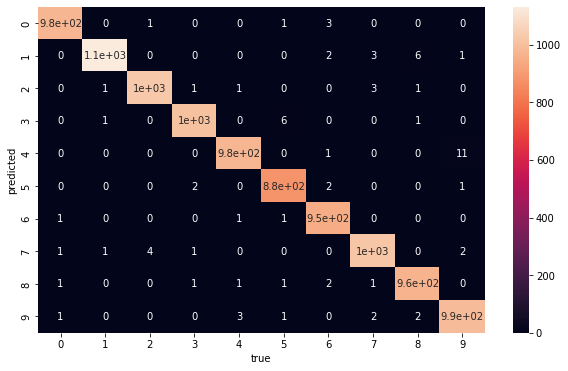

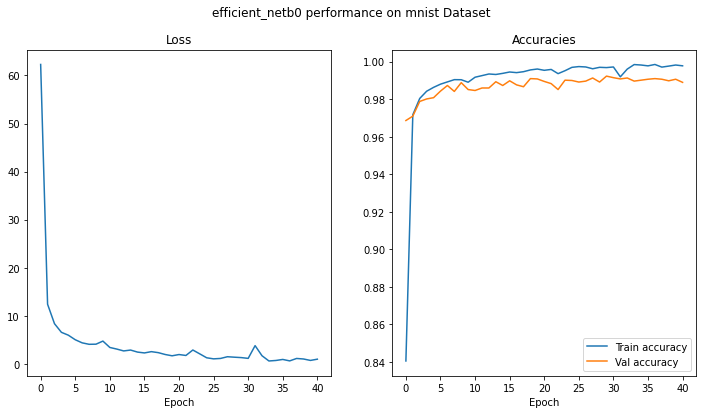

In [ ]:
efficientnet_b0 = models.efficientnet_b0().to(device)
efficientnet_b0.classifier = torch.nn.Sequential(torch.nn.Dropout(0.2),torch.nn.Linear(1280,10)).to(device)
optimizer = optim.Adam(efficientnet_b0.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 50
logs, heatmap = train_loop(efficientnet_b0, mnist_classes, mnist_train_loader, mnist_val_loader, mnist_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'efficient_netb0', dataset_name='mnist')
logs, heatmap = load_logs_N_heatmap('mnist','efficient_netb0')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'efficient_netb0 performance on mnist Dataset')

## EfficientNetb4

Epoch:  0
Time:  2022-05-09 15:16:42.282078
Train Accuracy:  tensor(0.7302, device='cuda:0')
Val Accuracy:  tensor(0.9480, device='cuda:0')
Epoch:  1
Time:  2022-05-09 15:17:37.119804
Train Accuracy:  tensor(0.9556, device='cuda:0')
Val Accuracy:  tensor(0.9715, device='cuda:0')
Epoch:  2
Time:  2022-05-09 15:18:31.664713
Train Accuracy:  tensor(0.9747, device='cuda:0')
Val Accuracy:  tensor(0.9727, device='cuda:0')
Epoch:  3
Time:  2022-05-09 15:19:26.366330
Train Accuracy:  tensor(0.9800, device='cuda:0')
Val Accuracy:  tensor(0.9762, device='cuda:0')
Epoch:  4
Time:  2022-05-09 15:20:20.799522
Train Accuracy:  tensor(0.9846, device='cuda:0')
Val Accuracy:  tensor(0.9792, device='cuda:0')
Epoch:  5
Time:  2022-05-09 15:21:15.444989
Train Accuracy:  tensor(0.9873, device='cuda:0')
Val Accuracy:  tensor(0.9838, device='cuda:0')
Epoch:  6
Time:  2022-05-09 15:22:10.005426
Train Accuracy:  tensor(0.9862, device='cuda:0')
Val Accuracy:  tensor(0.9807, device='cuda:0')
Epoch:  7
Time:  202

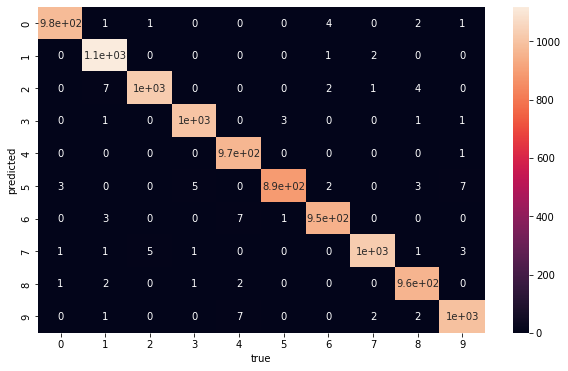

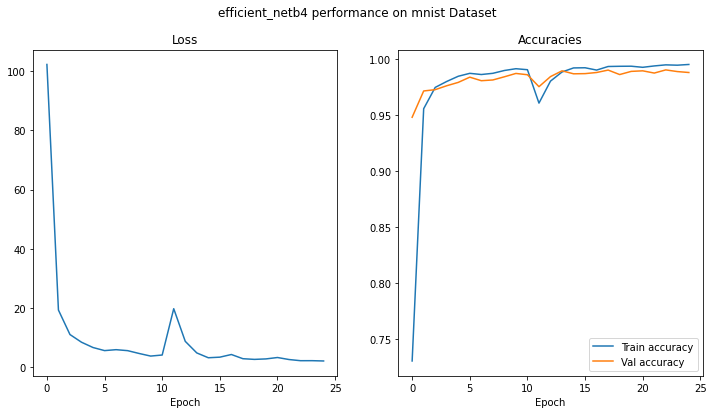

In [ ]:
efficientnet_b4 = models.efficientnet_b4().to(device)
efficientnet_b4.classifier = torch.nn.Sequential(torch.nn.Dropout(0.2),torch.nn.Linear(1792,10)).to(device)
optimizer = optim.Adam(efficientnet_b4.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 50
logs, heatmap = train_loop(efficientnet_b4, mnist_classes, mnist_train_loader, mnist_val_loader, mnist_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'efficient_netb4', dataset_name='mnist')
logs, heatmap = load_logs_N_heatmap('mnist','efficient_netb4')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'efficient_netb4 performance on mnist Dataset')

## Positive and negative examples from worst-performing classes on ResNet

9


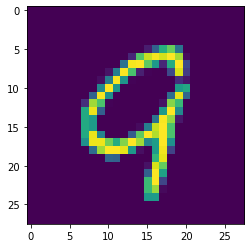

5


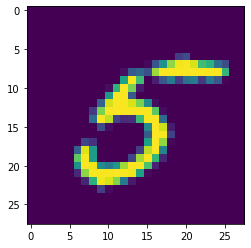

7


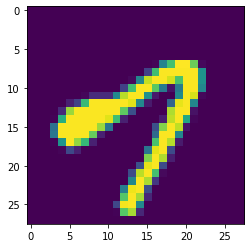

5


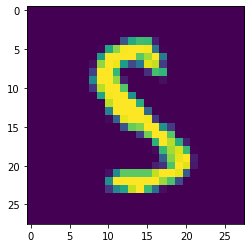

True: 8 but predicted 0


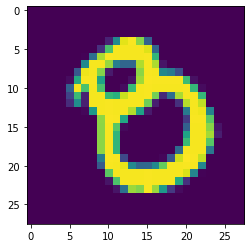

True: 6 but predicted 5


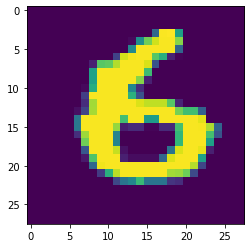

True: 7 but predicted 2


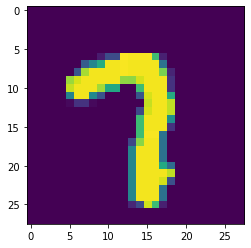

True: 6 but predicted 5


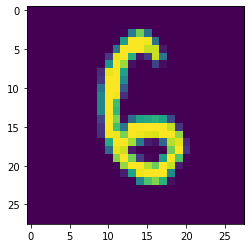

In [ ]:
posses, negs = investigate_classes(checkpoint='resnet_mnist/checkpoints/9resnetmnist.pt',dataset=mnist_testset, classes_inv = list(range(0,10)))
def reverse_trans(im):
  im = im.permute(1,2,0)
  im = (im*(torch.tensor(0.5).reshape(1,1,1)))
  return im 
for im, label in zip(posses['ims'], posses['true_labels']):
  im = im.to(torch.device('cpu'))
  im = reverse_trans(im[0])
  print(label)
  plt.imshow(im.reshape(28,28)); plt.show()

for im, label, pred in zip(negs['ims'], negs['true_labels'],negs['predicted_labels']):
  im = im.to(torch.device('cpu'))
  im = reverse_trans(im[0])
  print(f'True: {label} but predicted {pred}')
  plt.imshow(im.reshape(28,28)); plt.show()



# CIFAR

In [ ]:
means, stds =(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

##### Create dataloaders

cifar_train_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(means, stds)]
     )

cifar_val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means,stds)]
     )


cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_train_transform)
cifar_valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_val_transform)


cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=cifar_val_transform)

### Creating validation sampler
validation_percentage = 0.1
num_train = len(cifar_trainset)
indices = list(range(num_train))
split = int(validation_percentage * num_train)

#randomise the indices
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx) #this is an object the dataloader then needs
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 128

#CREATE DATALOADERS
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)

cifar_val_loader = torch.utils.data.DataLoader(cifar_valset, batch_size=batch_size,
                                           num_workers=4, sampler = valid_sampler)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size,
                                           num_workers=4)
cifar_classes = list(set(cifar_testset.targets))
cifar_class_names = cifar_testset.classes

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


torch.Size([32, 32, 3])


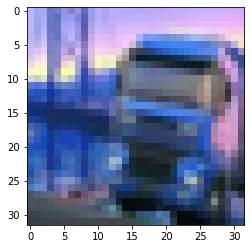

In [ ]:
#test iterator
dataiter = iter(cifar_train_loader)
images, labels = dataiter.next()
im = ((images[0]).permute(1,2,0))
print(im.shape)
plt.imshow(im*(torch.tensor(stds).reshape(1,1,3)) + torch.tensor(means).reshape(1,1,3)); plt.show()

## Resnet

Epoch:  0
Time:  2022-05-09 15:57:30.537248
Train Accuracy:  tensor(0.4966, device='cuda:0')
Val Accuracy:  tensor(0.5720, device='cuda:0')
Epoch:  1
Time:  2022-05-09 15:57:43.867809
Train Accuracy:  tensor(0.6448, device='cuda:0')
Val Accuracy:  tensor(0.6646, device='cuda:0')
Epoch:  2
Time:  2022-05-09 15:57:56.218821
Train Accuracy:  tensor(0.7126, device='cuda:0')
Val Accuracy:  tensor(0.6914, device='cuda:0')
Epoch:  3
Time:  2022-05-09 15:58:08.153581
Train Accuracy:  tensor(0.7586, device='cuda:0')
Val Accuracy:  tensor(0.7144, device='cuda:0')
Epoch:  4
Time:  2022-05-09 15:58:20.546603
Train Accuracy:  tensor(0.7959, device='cuda:0')
Val Accuracy:  tensor(0.7224, device='cuda:0')
Epoch:  5
Time:  2022-05-09 15:58:32.538669
Train Accuracy:  tensor(0.8332, device='cuda:0')
Val Accuracy:  tensor(0.7264, device='cuda:0')
Epoch:  6
Time:  2022-05-09 15:58:44.672468
Train Accuracy:  tensor(0.8630, device='cuda:0')
Val Accuracy:  tensor(0.7478, device='cuda:0')
Epoch:  7
Time:  202

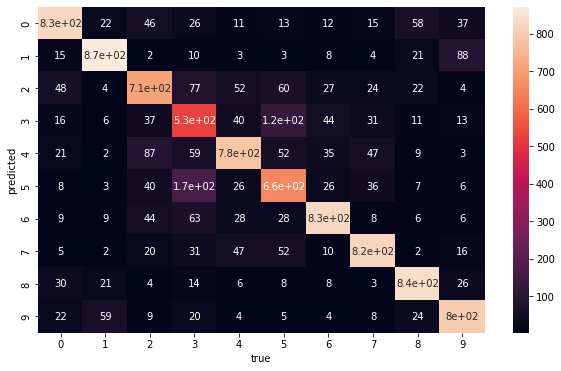

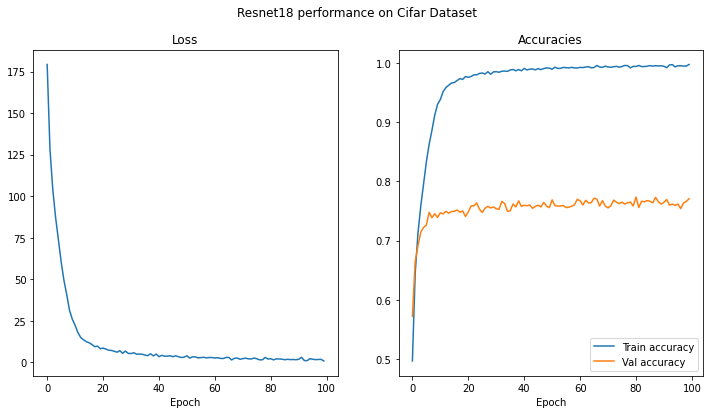

In [ ]:
resnet18 = models.resnet18().to(device)
resnet18.fc = torch.nn.Linear(512,10).to(device)
optimizer = optim.Adam(resnet18.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 100
logs, heatmap = train_loop(resnet18, cifar_classes, cifar_train_loader, cifar_val_loader, cifar_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'resnet', dataset_name='cifar',patience=25)
logs, heatmap = load_logs_N_heatmap('cifar','resnet')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'Resnet18 performance on Cifar Dataset')

## gNet

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:50: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


Epoch:  0
Time:  2022-05-09 16:18:29.811386


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Train Accuracy:  tensor(0.4159, device='cuda:0')
Val Accuracy:  tensor(0.5142, device='cuda:0')
New Best:  0.51419997215271
Epoch:  1
Time:  2022-05-09 16:18:50.731753
Train Accuracy:  tensor(0.5995, device='cuda:0')
Val Accuracy:  tensor(0.6384, device='cuda:0')
New Best:  0.6384000182151794
Epoch:  2
Time:  2022-05-09 16:19:11.156962
Train Accuracy:  tensor(0.6834, device='cuda:0')
Val Accuracy:  tensor(0.7006, device='cuda:0')
New Best:  0.7006000280380249
Epoch:  3
Time:  2022-05-09 16:19:31.461428
Train Accuracy:  tensor(0.7313, device='cuda:0')
Val Accuracy:  tensor(0.7338, device='cuda:0')
New Best:  0.7337999939918518
Epoch:  4
Time:  2022-05-09 16:19:52.167080
Train Accuracy:  tensor(0.7715, device='cuda:0')
Val Accuracy:  tensor(0.7520, device='cuda:0')
New Best:  0.7519999742507935
Epoch:  5
Time:  2022-05-09 16:20:12.846980
Train Accuracy:  tensor(0.7992, device='cuda:0')
Val Accuracy:  tensor(0.7380, device='cuda:0')
1
Epoch:  6
Time:  2022-05-09 16:20:33.452206
Train Accu

,N,correct,accuracy
0,1000.0,839.0,0.839
1,1000.0,877.0,0.877
2,1000.0,725.0,0.725
3,1000.0,662.0,0.662
4,1000.0,768.0,0.768
5,1000.0,687.0,0.687
6,1000.0,824.0,0.824
7,1000.0,820.0,0.820
8,1000.0,870.0,0.870
9,1000.0,864.0,0.864


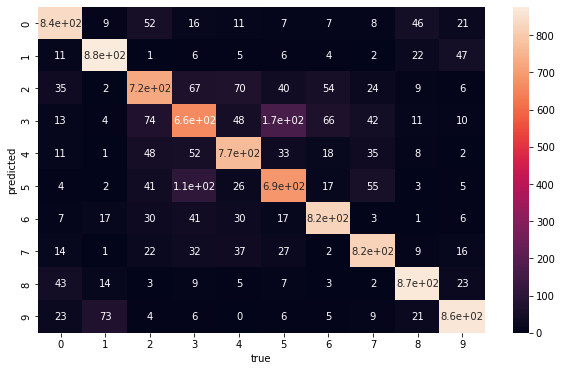

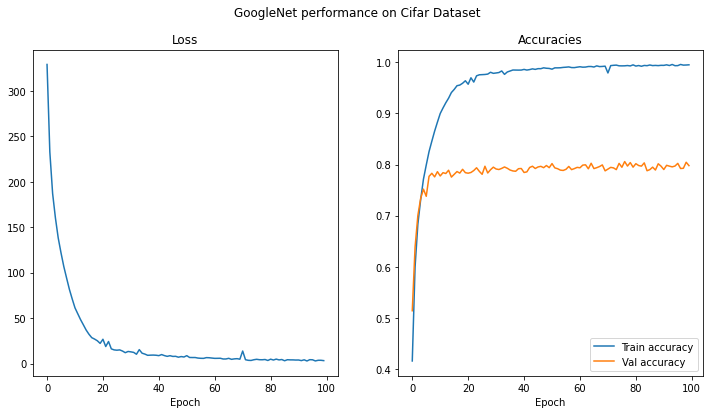

In [ ]:
googleLeNet = models.googlenet().to(device)
googleLeNet.fc = torch.nn.Linear(1024,10).to(device)
optimizer = optim.Adam(googleLeNet.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 100
logsGN, heatmapGN = train_loop_googleNet(googleLeNet, cifar_classes, cifar_train_loader, cifar_val_loader, cifar_test_loader, epochs, optimizer, loss_func, accuracy,model_name = 'googlenet', dataset_name='cifar',patience=25)
logs, heatmap = load_logs_N_heatmap('cifar','googlenet')
plot_confmatrix(heatmap)
display(pd.DataFrame(logs['Test log']['ind. class breakdown']).T)
plot_loss_and_accs(logs,'GoogleNet performance on Cifar Dataset')


## Resnet50

Epoch:  0
Time:  2022-05-09 16:51:48.173943
Train Accuracy:  tensor(0.3836, device='cuda:0')
Val Accuracy:  tensor(0.4984, device='cuda:0')
Epoch:  1
Time:  2022-05-09 16:52:13.873159
Train Accuracy:  tensor(0.4977, device='cuda:0')
Val Accuracy:  tensor(0.5140, device='cuda:0')
Epoch:  2
Time:  2022-05-09 16:52:38.642373
Train Accuracy:  tensor(0.5193, device='cuda:0')
Val Accuracy:  tensor(0.4346, device='cuda:0')
Epoch:  3
Time:  2022-05-09 16:53:03.701028
Train Accuracy:  tensor(0.5318, device='cuda:0')
Val Accuracy:  tensor(0.6222, device='cuda:0')
Epoch:  4
Time:  2022-05-09 16:53:28.978992
Train Accuracy:  tensor(0.6130, device='cuda:0')
Val Accuracy:  tensor(0.5592, device='cuda:0')
Epoch:  5
Time:  2022-05-09 16:53:54.680480
Train Accuracy:  tensor(0.5169, device='cuda:0')
Val Accuracy:  tensor(0.4056, device='cuda:0')
Epoch:  6
Time:  2022-05-09 16:54:19.838280
Train Accuracy:  tensor(0.5139, device='cuda:0')
Val Accuracy:  tensor(0.4824, device='cuda:0')
Epoch:  7
Time:  202

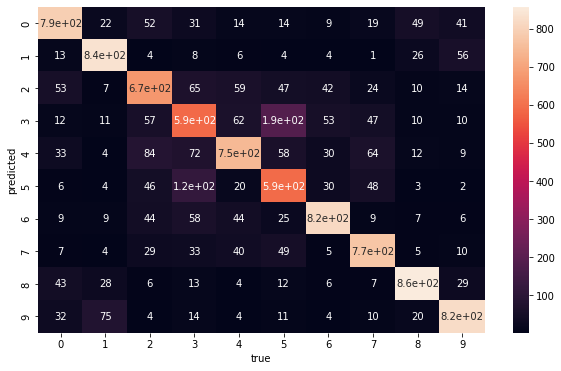

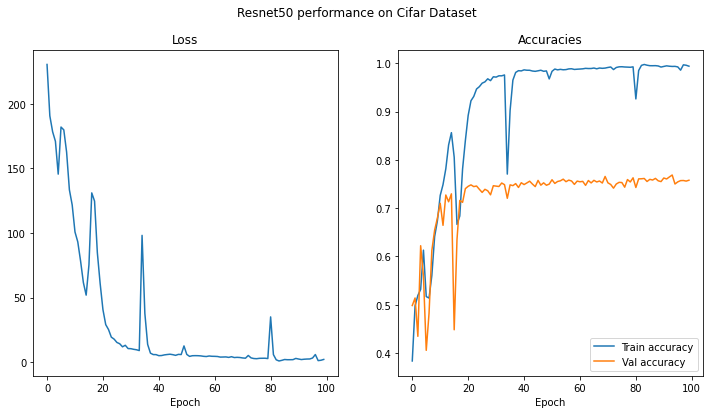

In [ ]:
resnet50 = models.resnet50().to(device)
resnet50.fc = torch.nn.Linear(2048,10).to(device)
optimizer = optim.Adam(resnet50.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 100
logs, heatmap = train_loop(resnet50, cifar_classes, cifar_train_loader, cifar_val_loader, cifar_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'resnet50', dataset_name='cifar',patience=25)
logs, heatmap = load_logs_N_heatmap('cifar','resnet50')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'Resnet50 performance on Cifar Dataset')

## EfficientNet

Epoch:  0
Time:  2022-05-09 17:32:07.271046
Train Accuracy:  tensor(0.2674, device='cuda:0')
Val Accuracy:  tensor(0.3864, device='cuda:0')
Epoch:  1
Time:  2022-05-09 17:32:29.108499
Train Accuracy:  tensor(0.4246, device='cuda:0')
Val Accuracy:  tensor(0.4696, device='cuda:0')
Epoch:  2
Time:  2022-05-09 17:32:50.378476
Train Accuracy:  tensor(0.5029, device='cuda:0')
Val Accuracy:  tensor(0.5518, device='cuda:0')
Epoch:  3
Time:  2022-05-09 17:33:11.406408
Train Accuracy:  tensor(0.5683, device='cuda:0')
Val Accuracy:  tensor(0.5820, device='cuda:0')
Epoch:  4
Time:  2022-05-09 17:33:32.618190
Train Accuracy:  tensor(0.6130, device='cuda:0')
Val Accuracy:  tensor(0.6156, device='cuda:0')
Epoch:  5
Time:  2022-05-09 17:33:53.760230
Train Accuracy:  tensor(0.6531, device='cuda:0')
Val Accuracy:  tensor(0.6238, device='cuda:0')
Epoch:  6
Time:  2022-05-09 17:34:14.929092
Train Accuracy:  tensor(0.6868, device='cuda:0')
Val Accuracy:  tensor(0.6606, device='cuda:0')
Epoch:  7
Time:  202

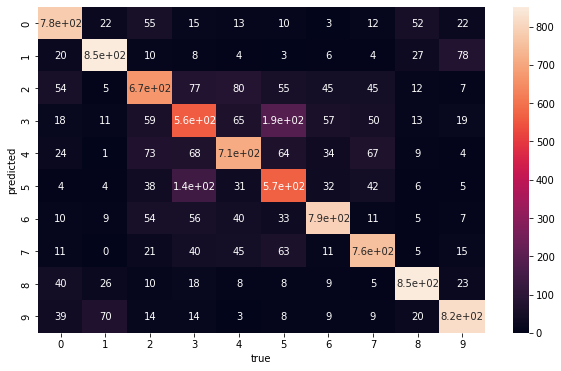

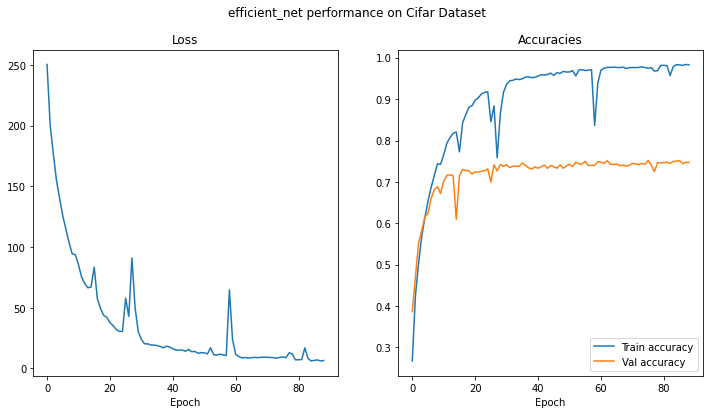

In [ ]:
efficientnet_b0 = models.efficientnet_b0().to(device)
efficientnet_b0.classifier = torch.nn.Sequential(torch.nn.Dropout(0.2),torch.nn.Linear(1280,10)).to(device)
optimizer = optim.Adam(efficientnet_b0.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 100
logs, heatmap = train_loop(efficientnet_b0, cifar_classes, cifar_train_loader, cifar_val_loader, cifar_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'efficient_net', dataset_name='cifar',patience=25)
logs, heatmap = load_logs_N_heatmap('cifar','efficient_net')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'efficient_net performance on Cifar Dataset')

In [ ]:

efficientnet_b4 = models.efficientnet_b4().to(device)
efficientnet_b4.classifier = torch.nn.Sequential(torch.nn.Dropout(0.2),torch.nn.Linear(1792,10)).to(device)
optimizer = optim.Adam(efficientnet_b4.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 100
logs, heatmap = train_loop(efficientnet_b4, cifar_classes, cifar_train_loader, cifar_val_loader, cifar_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'efficient_netB4', dataset_name='cifar',patience=25)
logs, heatmap = load_logs_N_heatmap('cifar','efficient_netB4')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'efficient_netB4 performance on Cifar Dataset')

## Investigating Class 3 (truck) and 5 (automobile) correct and incorrect classification

#### Using current best classifier (gNet on data aug)

In [ ]:
posses, negs = investigate_classes(checkpoint='googlenet_cifar/checkpoints/9googlenetcifar.pt',dataset=cifar_trainset, classes_inv = [3,5])
def reverse_trans(im):
  im = im.permute(1,2,0)
  im = (im*(torch.tensor(stds).reshape(1,1,3)) + torch.tensor(means).reshape(1,1,3))
  return im 
for im, label in zip(posses['ims'], posses['true_labels']):
  im = im.to(torch.device('cpu'))
  im = reverse_trans(im[0])
  print(cifar_class_names[label])
  plt.imshow(im); plt.show()
for im, label, pred in zip(negs['ims'], negs['true_labels'],negs['predicted_labels']):
  im = im.to(torch.device('cpu'))
  im = reverse_trans(im[0])
  print(f'True: {list_of_class_names[label]} but predicted {list_of_class_names[pred]}')
  plt.imshow(im); plt.show()

# Experiment 1 - Applying Data Augmentation

## Loading new data

In [ ]:
##### Create dataloaders

cifar_train_transform_augHorFlip = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds),
     transforms.RandomHorizontalFlip(0.5),
     ])



cifar_train_transform_augRdmRot = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds),
     transforms.RandomRotation(30),
     ])

cifar_train_transform_Sharper = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds),
     transforms.RandomAdjustSharpness(2, p=0.5)
     ])

cifar_train_transform_Blurrer = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds),
     transforms.RandomAdjustSharpness(0, p=0.5)
     ])

cifar_train_transform_Crop = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds),
     transforms.RandomCrop(26)
     ])


cifar_val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds)])


cifar_trainset_augHorFlip = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_train_transform_augHorFlip)
cifar_trainset_augRdmRot = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_train_transform_augRdmRot)
cifar_trainset_augSharper = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_train_transform_Sharper)
cifar_trainset_augBlurrer = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_train_transform_Blurrer)
cifar_trainset_augCrop = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_train_transform_Crop)


cifar_valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_val_transform)


cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=cifar_val_transform)

### Creating validation sampler
validation_percentage = 0.1
num_train = len(cifar_trainset)
indices = list(range(num_train))
split = int(validation_percentage * num_train)

#randomise the indices
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx) #this is an object the dataloader then needs
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 128

#CREATE DATALOADERS
cifar_train_loader_augHorFlip = torch.utils.data.DataLoader(cifar_trainset_augHorFlip, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)
cifar_train_loader_augRdmRot = torch.utils.data.DataLoader(cifar_trainset_augRdmRot, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)
cifar_train_loader_augSharper = torch.utils.data.DataLoader(cifar_trainset_augSharper, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)
cifar_train_loader_augBlurrer = torch.utils.data.DataLoader(cifar_trainset_augBlurrer, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)
cifar_train_loader_augCrop = torch.utils.data.DataLoader(cifar_trainset_augCrop, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)


cifar_val_loader = torch.utils.data.DataLoader(cifar_valset, batch_size=batch_size,
                                           num_workers=4, sampler = valid_sampler)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size,
                                           num_workers=4)
cifar_classes = list(set(cifar_testset.targets))

## Gnet Performance on data augmentation

1.   Note: Inaccurately entitle "resnetDataAug" -> all augmentation models were actually done with a gNet baseline



In [ ]:
for dl, name in zip([cifar_train_loader_augHorFlip, cifar_train_loader_augRdmRot, cifar_train_loader_augSharper, cifar_train_loader_augBlurrer],["cifgNetAugHor","cifgNetAugRot","cifgNetAugShar","cifgNetAugBlur"]):
    googleLeNet = models.googlenet().to(device)
    googleLeNet.fc = torch.nn.Linear(1024,10).to(device)
    optimizer = optim.Adam(googleLeNet.parameters())
    loss_func = nn.CrossEntropyLoss().to(device)
    accuracy = torchmetrics.Accuracy().to(device)
    epochs = 100
    logs, heatmap = train_loop_googleNet(googleLeNet, cifar_classes, dl, cifar_val_loader, cifar_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'resnet_dataAug', dataset_name=name)
    logs, heatmap = load_logs_N_heatmap(name,'resnet_dataAug')
    plot_confmatrix(heatmap)
    pd.DataFrame(logs['Test log']['ind. class breakdown']).T
    plot_loss_and_accs(logs,f'Resnet performance - {name}')

In [ ]:
#### Adding a fifth (cropping)
googleLeNet = models.googlenet().to(device)
googleLeNet.fc = torch.nn.Linear(1024,10).to(device)
optimizer = optim.Adam(googleLeNet.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 100
logs, heatmap = train_loop_googleNet(googleLeNet, cifar_classes, cifar_train_loader_augCrop, cifar_val_loader, cifar_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'resnet_dataAug', dataset_name='cifgNetAugCrop')
logs, heatmap = load_logs_N_heatmap('cifgNetAugCrop','resnet_dataAug')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,f'Resnet performance - cifgNetAugCrop')

Analysis

Random rotations and mirroring increase validation performance.

Now experimenting with these two together

In [ ]:
cifar_train_transform_FlipRot = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds),
     transforms.RandomHorizontalFlip(0.5),
     transforms.RandomRotation(30),
     ])
cifar_trainset_FlipRot = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_train_transform_FlipRot)

cifar_train_loader_FlipRot = torch.utils.data.DataLoader(cifar_trainset_FlipRot, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)
#### Adding a fifth (cropping)
googleLeNet = models.googlenet().to(device)
googleLeNet.fc = torch.nn.Linear(1024,10).to(device)
optimizer = optim.Adam(googleLeNet.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 100
logs, heatmap = train_loop_googleNet(googleLeNet, cifar_classes, cifar_train_loader_FlipRot, cifar_val_loader, cifar_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'gNet_dataAug', dataset_name='cifgNetFlipRot')


In [ ]:
logs, heatmap = load_logs_N_heatmap('cifgNetFlipRot','gNet_dataAug')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,f'gNet performance - cifgNetFlipRot')

# Experiment 2 - zero centreing

In [ ]:
##### Create dataloaders
means = (0,0,0)
stds = (0.33, 0.33,0.33)
cifar_train_transform_norm_centre = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds),
     transforms.RandomHorizontalFlip(0.5),
     ])


cifar_val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds)])


cifar_trainset_norm_centre = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_train_transform_norm_centre)

cifar_valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_val_transform)


cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=cifar_val_transform)

### Creating validation sampler
validation_percentage = 0.1
num_train = len(cifar_trainset)
indices = list(range(num_train))
split = int(validation_percentage * num_train)

#randomise the indices
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx) #this is an object the dataloader then needs
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 128

#CREATE DATALOADERS
cifar_train_loader_0cntr = torch.utils.data.DataLoader(cifar_trainset_norm_centre, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)

cifar_val_loader = torch.utils.data.DataLoader(cifar_valset, batch_size=batch_size,
                                           num_workers=4, sampler = valid_sampler)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size,
                                           num_workers=4)
cifar_classes = list(set(cifar_testset.targets))

In [ ]:
##Centring around 0
googleLeNet = models.googlenet().to(device)
googleLeNet.fc = torch.nn.Linear(1024,10).to(device)
optimizer = optim.Adam(googleLeNet.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 100
logs, heatmap = train_loop_googleNet(googleLeNet, cifar_classes, cifar_train_loader_0cntr, cifar_val_loader, cifar_test_loader, epochs, optimizer, loss_func, accuracy, model_name = 'gNet_dataAug_0cntr', dataset_name='cifgNetFlipRot')

logs, heatmap = load_logs_N_heatmap('cifgNetFlipRot','gNet_dataAug_0cntr')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,f'gNet_0cntr performance - cifgNetFlipRot')

# CIFAR 100

Using Data Augmentation

In [ ]:
##### Create dataloaders
means, stds =(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
cifar_train_transform_FlipRot = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds),
     transforms.RandomHorizontalFlip(0.5),
     transforms.RandomRotation(30),
     ])

cifar_val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means,stds)]
     )


cifar_trainset_cif100 = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=cifar_train_transform_FlipRot)

cifar_valset_cif100 = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=cifar_val_transform)

cifar_testset_cif100 = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=cifar_val_transform)

### Creating validation sampler
validation_percentage = 0.1
num_train = len(cifar_trainset_cif100)
indices = list(range(num_train))
split = int(validation_percentage * num_train)

#randomise the indices
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx) #this is an object the dataloader then needs
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 128

#CREATE DATALOADERS
cifar_train_loader_cif100 = torch.utils.data.DataLoader(cifar_trainset_cif100, batch_size=batch_size,
                                           num_workers=4, sampler = train_sampler)
cifar_val_loader_cif100 = torch.utils.data.DataLoader(cifar_valset_cif100, batch_size=batch_size,
                                           num_workers=4, sampler = valid_sampler)
cifar_test_loader_cif100 = torch.utils.data.DataLoader(cifar_testset_cif100, batch_size=batch_size,
                                           num_workers=4)
cifar100_classes = list(set(cifar_testset_cif100.targets))
cifar100_class_names = cifar_testset_cif100.classes



## Resnet18

In [ ]:
resnet18 = models.resnet18().to(device)
resnet18.fc = torch.nn.Linear(512,100).to(device)
optimizer = optim.Adam(resnet18.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 150
logs, heatmap = train_loop(resnet18, cifar100_classes, cifar_train_loader_cif100, cifar_val_loader_cif100, cifar_test_loader_cif100, epochs, optimizer, loss_func, accuracy, model_name = 'resnet', dataset_name='cifar100',patience=25)
logs, heatmap = load_logs_N_heatmap('cifar100','resnet')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'Resnet18 performance on Cifar Dataset')

## Resnet50

In [ ]:
resnet50 = models.resnet50().to(device)
resnet50.fc = torch.nn.Linear(2048,100).to(device)
optimizer = optim.Adam(resnet50.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 150
logs, heatmap = train_loop(resnet50, cifar100_classes, cifar_train_loader_cif100, cifar_val_loader_cif100, cifar_test_loader_cif100, epochs, optimizer, loss_func, accuracy, model_name = 'resnet50', dataset_name='cifar100',patience=25)
logs, heatmap = load_logs_N_heatmap('cifar100','resnet50')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'Resnet50 performance on Cifar Dataset')

## googleNet


In [ ]:

googleLeNet = models.googlenet().to(device)
googleLeNet.fc = torch.nn.Linear(1024,100).to(device)
optimizer = optim.Adam(googleLeNet.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 150
logs, heatmap = train_loop_googleNet(googleLeNet, cifar100_classes, cifar_train_loader_cif100, cifar_val_loader_cif100, cifar_test_loader_cif100, epochs, optimizer, loss_func, accuracy, model_name = 'gNet', dataset_name='cifar100',patience=25)

logs, heatmap = load_logs_N_heatmap('cifar100','gNet')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'gNet Cifar 100')

## Efficient_net b0


In [ ]:
efficientnet_b0 = models.efficientnet_b0().to(device)
efficientnet_b0.classifier = torch.nn.Sequential(torch.nn.Dropout(0.2),torch.nn.Linear(1280,100)).to(device)
optimizer = optim.Adam(efficientnet_b0.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 150
logs, heatmap = train_loop(efficientnet_b0, cifar100_classes, cifar_train_loader_cif100, cifar_val_loader_cif100, cifar_test_loader_cif100, epochs, optimizer, loss_func, accuracy, model_name = 'efficient_netB0', dataset_name='cifar100', patience=25)
logs, heatmap = load_logs_N_heatmap('cifar100','efficient_netB0')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'efficient_net performance on Cifar Dataset')


## Efficent_net b4

In [ ]:
efficientnet_b4 = models.efficientnet_b4().to(device)
efficientnet_b4.classifier = torch.nn.Sequential(torch.nn.Dropout(0.2),torch.nn.Linear(1792,100)).to(device)
optimizer = optim.Adam(efficientnet_b4.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 150
logs, heatmap = train_loop(efficientnet_b4, cifar100_classes, cifar_train_loader_cif100, cifar_val_loader_cif100, cifar_test_loader_cif100, epochs, optimizer, loss_func, accuracy, model_name = 'efficient_netB4', dataset_name='cifar100',patience=25)
logs, heatmap = load_logs_N_heatmap('cifar','efficient_netB4')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'efficient_netB4 performance on Cifar Dataset')

# Experiment 3 - Removing auxilliary output heads from gNet

GNet performs better than ResNet / EfficientNet on all datasets.

This could be the inception-style network, or it may be driven by the auxilliary heads.

In experiment 3, the auxilliary heads are removed

In [ ]:
def train_loop_googleNet_remove_heads(model,class_list,train_loader, val_loader, test_loader, epochs, optimizer, loss_func, accuracy_metric, dataset_name='mnist',model_name='resnet',patience=10):
    best_epoch = 0
    best_perf = 0.0
    early_stop_counter = 0
    log_folder, checkpoint_folder = create_folders(model_name,dataset_name)

    logs = {}
    for e in range(epochs):
        print("Epoch: ", e)
        #train
        loss_cum = 0
        logs[f'Epoch{e}'] = {}
        ct = datetime.datetime.now()
        print("Time: ", str(ct))
        logs[f'Epoch{e}']['time_stamp'] = str(ct)
        for data in train_loader:
            x , y = data
            x, y = x.to(device), y.long().to(device)
            outputs = model(x)
            loss = loss_func(outputs[0], y)
            # loss += 0.3 * loss_func(outputs[1], y)
            # loss += 0.3 * loss_func(outputs[2], y)
            loss_cum += loss.item()
            loss.backward()
            optimizer.step(); optimizer.zero_grad()
            accuracy_metric(outputs[0],y)
        acc = accuracy_metric.compute()

        print('Train Accuracy: ', acc)
        logs[f'Epoch{e}']['loss'] = (loss_cum * batch_size / len(train_loader))
        logs[f'Epoch{e}']['train_accuracy'] = float(acc.detach().cpu().numpy())
        accuracy_metric.reset()
        torch.save(model, f'{checkpoint_folder}/{e}{model_name}{dataset_name}.pt')
        #validation
        with torch.no_grad():
          for data in val_loader:
              x , y = data
              x, y = x.to(device), y.long().to(device)
              outputs = model(x)
              accuracy_metric(outputs[0],y)
        acc = accuracy_metric.compute()

        logs[f'Epoch{e}']['val_accuracy'] = float(acc.detach().cpu().numpy())
        print('Val Accuracy: ', acc)
        if acc > best_perf + 0.001:
          best_epoch =e
          early_stop_counter = 0
          best_perf = acc.item()
          print("New Best: ", best_perf)
        else:
          early_stop_counter += 1
          print(early_stop_counter)
        accuracy_metric.reset()
        if early_stop_counter > patience:
          break
        

    #testing
    test_log = {}
    test_log['timestamp'] = str(datetime.datetime.now())
    classes = set([int(x) for x in (class_list)])
    heatmap_array = np.zeros((len(classes), len(classes)))
    classes_acc = {}
    for c in classes:
      classes_acc[c] = {'N':0, 'correct':0}

    with torch.no_grad():
      for data in test_loader:
          x , y = data  
          x, y = x.to(device), y.long().to(device)
          outputs = model(x)
          accuracy_metric(outputs[0],y)
          prediction = torch.argmax(outputs[0], dim=1, keepdim=False)
          for c in classes:
            classes_acc[c]['N'] += int((torch.sum(y == c)).detach().cpu().numpy())
            classes_acc[c]['correct'] += int((torch.sum((y==c) * (y==prediction))).detach().cpu().numpy())
          for pred, true in zip(prediction, y):
            heatmap_array[pred,true] += 1
    for c in classes:
      classes_acc[c]['accuracy'] = classes_acc[c]['correct'] / classes_acc[c]['N']
    test_log['ind. class breakdown'] = classes_acc
    acc = accuracy_metric.compute()
    test_log['overall_accuracy'] = float(acc.detach().cpu().numpy())
    logs['Test log'] = test_log
    print('Test Accuracy: ', acc)
    accuracy_metric.reset()
    
    with open(log_folder+'/loss_and_accuracy.json', "w") as fp:
      json.dump(logs,fp)  
    np.save(log_folder+'/heatmap.npy', heatmap_array)
    
    return logs, heatmap_array


In [ ]:
googleLeNet = models.googlenet().to(device)
googleLeNet.fc = torch.nn.Linear(1024,100).to(device)
optimizer = optim.Adam(googleLeNet.parameters())
loss_func = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy().to(device)
epochs = 150
logs, heatmap = train_loop_googleNet_remove_heads(googleLeNet, cifar100_classes, cifar_train_loader_cif100, cifar_val_loader_cif100, cifar_test_loader_cif100, epochs, optimizer, loss_func, accuracy, model_name = 'gNet_no_aux_heads', dataset_name='cifar100',patience=25)

logs, heatmap = load_logs_N_heatmap('cifar100','gNet_no_aux_heads')
plot_confmatrix(heatmap)
pd.DataFrame(logs['Test log']['ind. class breakdown']).T
plot_loss_and_accs(logs,'gNet_no_aux Cifar 100')